# Bước 1: Import Modules

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from io import BytesIO
import pandas as pd
import numpy as np
import requests
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.7.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Bước 2: Load bộ dữ liệu PhoNER

Thông tin các thực thể:

<b>PATIENT_ID</b>: Unique identifier of a COVID-19 patient in Vietnam. An PATIENT_ID annotation over “X” refers to as the Xth patient having COVID-19 in Vietnam.<br>
<b>PERSON_NAME</b>: Name of a patient or person who comes into contact with a patient.<br>
<b>AGE</b>: Age of a patient or person who comes into contact with a patient.
<b>GENDER</b>: Gender of a patient or person who comes into contact with a patient.<br>
<b>OCCUPATION</b>: Job of a patient or person who comes into contact with a patient.<br>
<b>LOCATION</b>: Locations/places that a patient was presented at.<br>
<b>ORGANIZATION</b>: Organizations related to a patient, e.g. company, government organization, and
the like, with structures and their own functions.<br>
<b>SYMPTOM&DISEASE</b>: Symptoms that a patient experiences, and diseases that a patient had prior to
COVID-19 or complications that usually appear in death reports.<br>
<b>TRANSPORTATION</b>: Means of transportation that a patient used. Here, we only tag the specific
identifier of vehicles, e.g. flight numbers and bus/car plates.<br>
<b>DATE</b>: Any date that appears in the sentence.<br>
Sau khi đọc tập dữ liệu, chúng ta quan sát thử 2 câu đầu tiên như thế nào.


In [ ]:
!git clone https://github.com/VinAIResearch/PhoNER_COVID19.git
%cd /content/PhoNER_COVID19

Cloning into 'PhoNER_COVID19'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 32 (delta 9), reused 17 (delta 7), pack-reused 0
Unpacking objects: 100% (32/32), done.
/content/PhoNER_COVID19


In [ ]:
#Hàm này sẽ load dữ liệu đồng thời xử lý tạo danh sách các Word và Tag đã được loại bỏ giá trị trùng + Thêm phần đệm ENDPAD vào word
def read_conll_file(in_file_list):
  sentence,wt,word,tag = [],[],[],[]
  for in_file in in_file_list:
    with open(in_file) as f:
        for line in f.readlines():
            sp = line.strip().split('\t')
            word_tag = tuple(sp[0].split(" "))
            if len(word_tag) > 1:
              word.append(word_tag[0])
              tag.append(word_tag[1])
              wt.append(tuple(word_tag))
            else:
              sentence.append(wt)
              wt = []
  word = list(set(word))
  word.append("ENDPAD")
  tag = list(set(tag))
  return sentence,word,tag

In [ ]:
in_file_list = ["./data/word/train_word.conll","./data/word/dev_word.conll","./data/word/test_word.conll"]
sentence,words,tags = read_conll_file(in_file_list)
sentence[:50]

[[('Đồng_thời', 'O'),
  (',', 'O'),
  ('bệnh_viện', 'O'),
  ('tiếp_tục', 'O'),
  ('thực_hiện', 'O'),
  ('các', 'O'),
  ('biện_pháp', 'O'),
  ('phòng_chống', 'O'),
  ('dịch_bệnh', 'O'),
  ('COVID', 'O'),
  ('-', 'O'),
  ('19', 'O'),
  ('theo', 'O'),
  ('hướng_dẫn', 'O'),
  ('của', 'O'),
  ('Bộ', 'B-ORGANIZATION'),
  ('Y_tế', 'I-ORGANIZATION'),
  ('.', 'O')],
 [('"', 'O'),
  ('Số', 'O'),
  ('bệnh_viện', 'O'),
  ('có_thể', 'O'),
  ('tiếp_nhận', 'O'),
  ('bệnh_nhân', 'O'),
  ('bị', 'O'),
  ('sốt', 'B-SYMPTOM_AND_DISEASE'),
  ('cao', 'I-SYMPTOM_AND_DISEASE'),
  ('và', 'O'),
  ('khó', 'B-SYMPTOM_AND_DISEASE'),
  ('thở', 'I-SYMPTOM_AND_DISEASE'),
  ('đang', 'O'),
  ('giảm', 'O'),
  ('dần', 'O'),
  ('"', 'O'),
  (',', 'O'),
  ('thông_cáo', 'O'),
  ('có', 'O'),
  ('đoạn', 'O'),
  (',', 'O'),
  ('cảnh_báo', 'O'),
  ('những', 'O'),
  ('bệnh_nhân', 'O'),
  ('này', 'O'),
  ('thay', 'O'),
  ('vào', 'O'),
  ('đó', 'O'),
  ('được', 'O'),
  ('chuyển', 'O'),
  ('tới', 'O'),
  ('các', 'O'),
  ('phòng_khá

Thống kê bộ dữ liệu:
- Số lượng từ duy nhất trong kho ngữ liệu.
- Số lượng thẻ duy nhất trong tập dữ liệu.\

In [ ]:
print("Unique words in corpus:", len(words)-1)
print("Unique tags in corpus:", len(tags))

Unique words in corpus: 8101
Unique tags in corpus: 21


In [ ]:
num_words = len(words)
print(words)
print(num_words)

['Khác', 'triệu_chứng', 'võ_sư', '448', '1008', '0', '2/69', 'Mẫu', 'Tiệp', 'Kỹ_thuật', 'Khoa_Nhiễm', 'Hoằng_Hoá', 'tế', 'biểu_diễn', 'Thi_Sách', 'nhất_định', 'Chung_cư', 'Sigma', 'ổn_định', 'Hơn_nữa', 'khó_khăn', 'trao_đổi', 'khan_hiếm', '989', 'cuộc_sống', 'bảo_đảm', 'lúc', 'nhờ', 'chỉ_đạo', 'Ngọc_Quang', 'Lê_Tuyết', 'Mỹ_về', 'Yên_Lạc', 'Vương_Đình_Huệ', 'xăng', 'Sun', 'nôn_mửa', 'Biện_pháp', 'chuyến', 'Nguyễn_Văn_Quá', '1026', 'tổng_hợp', 'bão', 'thành_lập', 'mặc', 'công_trình', 'quy_cách', 'dám', 'Yangon', 'đòi_hỏi', 'Minh_Khai', 'Trưởng', '189', 'Phong_Nha', 'Quang_Vinh', '849', 'Nghĩ', 'lớn_tuổi', 'mạch', '584', 'Nữ_sinh', 'Ba_Đình', 'Phượng', 'Sam_Grand_Hotel', 'Viên', 'Chu', 'Phạm_Như_Xương', 'gấp_gáp', 'Nhiệm_vụ', 'Lý_do_viên', '1991', 'Tân_Dân', 'Nguyễn_Lương_Bằng', 'thoáng', '7/3', 'rửa', '8', 'Mười', 'Hơi', 'địa', 'cụ', 'Phước_Mỹ', '744', 'yếu_ớt', '1.007', 'chiếu', 'Kawasaki', 'sim', 'Bắc_Kạn', 'dạ_dày', 'cậu', 'Cẩm_Xuyên', 'Nội_Đồng', 'Duy_Tân', 'nội', 'Nguyễn_Anh_Nh

In [ ]:
num_tags = len(tags)
print(tags)
print(num_tags)

['I-TRANSPORTATION', 'I-AGE', 'I-PATIENT_ID', 'I-LOCATION', 'B-ORGANIZATION', 'O', 'I-ORGANIZATION', 'B-JOB', 'B-SYMPTOM_AND_DISEASE', 'I-JOB', 'B-NAME', 'B-LOCATION', 'B-GENDER', 'B-DATE', 'I-NAME', 'B-TRANSPORTATION', 'I-SYMPTOM_AND_DISEASE', 'I-DATE', 'O-ORGANIZATION', 'B-AGE', 'B-PATIENT_ID']
21


In [ ]:
print(len(words), len(tags))

8102 21


# Bước 4: Ánh xạ giữa các câu và chỉ mục
Chúng ta có thể thấy rằng mỗi từ được gán cho một thẻ duy nhất. Chúng tôi có thể truy xuất những từ này bằng cách sử dụng các chỉ số của chúng và tra cứu chúng trong từ điển và trả về các khóa tương ứng.


In [ ]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
# word2idx
tag2idx 

{'B-AGE': 19,
 'B-DATE': 13,
 'B-GENDER': 12,
 'B-JOB': 7,
 'B-LOCATION': 11,
 'B-NAME': 10,
 'B-ORGANIZATION': 4,
 'B-PATIENT_ID': 20,
 'B-SYMPTOM_AND_DISEASE': 8,
 'B-TRANSPORTATION': 15,
 'I-AGE': 1,
 'I-DATE': 17,
 'I-JOB': 9,
 'I-LOCATION': 3,
 'I-NAME': 14,
 'I-ORGANIZATION': 6,
 'I-PATIENT_ID': 2,
 'I-SYMPTOM_AND_DISEASE': 16,
 'I-TRANSPORTATION': 0,
 'O': 5,
 'O-ORGANIZATION': 18}

Bước 5: Padding  đầu vào and cắt dữ liệu thành tập Train/Test\
Độ dài của câu trong tập dữ liệu khoảng 20 đến 22 dấu từ. Và trong trục X, có thể thấy giá trị an toàn là khoảng 60.

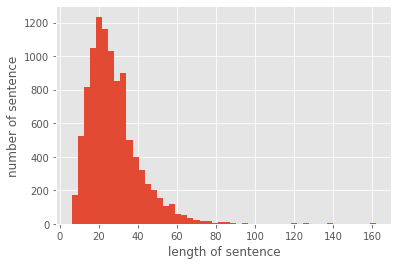

In [ ]:
plt.hist([len(s) for s in sentence], bins=50)
plt.xlabel("length of sentence")
plt.ylabel('number of sentence')
plt.show()

- Sử dụng hàm pad_sequence() cho padding
- X sẽ là một đại diện bằng số cho các từ. (sử dụng word2idx)
- ‘Post’ chỉ là một giá trị của đối số đệm ở cuối câu.
- X,y là vector

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 60
def ToSequence(sentences,max_len,num_words,num_tags):
  X = [[word2idx[w[0]] for w in s] for s in sentences]
  X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)
  y = [[tag2idx[w[1]] for w in s] for s in sentences]
  y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
  return X,y
X,y = ToSequence(sentence,max_len,num_words,num_tags)

In [ ]:
print(X[0])
print(y[0])

[2706 4945 3354 2630 4523 3382 5538 2093 1514  399 4082 5548 7599 5267
 1551 7770 1003  308 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101]
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


- test_size = 0.2 có nghĩa là 95% dữ liệu chia cho tập huấn luyện và 5% còn lại cho tập kiểm tra.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1)

# Bước 6: Xây dựng Mô hình


In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense,GRU,Conv1D
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.optimizers import Adam

## Bi-GRU CNN

In [ ]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(GRU(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
model = Conv1D(200,3,padding = "same",activation = "relu")(model)
model = Conv1D(200,4,padding = "same",activation = "relu")(model)
model = Conv1D(200,5,padding = "same",activation = "relu")(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.compile(optimizer=Adam(lr = 2e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60)]              0         
                                                                 
 embedding (Embedding)       (None, 60, 60)            486120    
                                                                 
 spatial_dropout1d (SpatialD  (None, 60, 60)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 60, 200)          97200     
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 60, 200)           120200    
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 200)           160200

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Bước7: Huấn luyện Model

- Để bắt đầu huấn luyện là gọi model.fit ()
- Có thể tăng kích thước batch_size nếu bạn có GPU có kích thước bộ nhớ lớn.



In [ ]:
# Các bạn nhớ là phải lưu mô hình khi train (có nhắc lại yêu cầu ở cuối) 
import time
start_time = time.time()
history = model.fit(
    x=X,
    y=y,
    #validation_data=(x_,y_valid),
    validation_split= 0.05,
    batch_size= 128, 
    epochs=10,
    verbose=1
)
print("[{}] Completed!".format(time.time() - start_time))


Epoch 1/10
75/75 [==============================] - 89s 712ms/step - loss: 1.1326 - accuracy: 0.8798 - val_loss: 0.4527 - val_accuracy: 0.9058
Epoch 2/10
75/75 [==============================] - 52s 697ms/step - loss: 0.4563 - accuracy: 0.8944 - val_loss: 0.3704 - val_accuracy: 0.9058
Epoch 3/10
75/75 [==============================] - 53s 702ms/step - loss: 0.3811 - accuracy: 0.8981 - val_loss: 0.2917 - val_accuracy: 0.9222
Epoch 4/10
75/75 [==============================] - 52s 690ms/step - loss: 0.2671 - accuracy: 0.9231 - val_loss: 0.1663 - val_accuracy: 0.9500
Epoch 5/10
75/75 [==============================] - 52s 692ms/step - loss: 0.1499 - accuracy: 0.9577 - val_loss: 0.1010 - val_accuracy: 0.9732
Epoch 6/10
75/75 [==============================] - 52s 698ms/step - loss: 0.1019 - accuracy: 0.9730 - val_loss: 0.0725 - val_accuracy: 0.9818
Epoch 7/10
75/75 [==============================] - 52s 688ms/step - loss: 0.0792 - accuracy: 0.9792 - val_loss: 0.0615 - val_accuracy: 0.9844

In [ ]:
model.save_weights("/content/drive/MyDrive/NCKH-WEIGHT&CFG/NLPforDS/BTTH3/Cau2_GRUCNN_weight.h5")
model.save("/content/drive/MyDrive/NCKH-WEIGHT&CFG/NLPforDS/BTTH3/Cau2_GRUUCNN.h5")

# Bước8: Đánh giá mô hình NER


In [ ]:
model.evaluate(x_test, y_test)

16/16 [==============================] - 1s 76ms/step - loss: 0.0421 - accuracy: 0.9884


[0.04209001734852791, 0.9883798360824585]

- Dự đoán

In [ ]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
Đơn_cử         O	O
"              O	O
bệnh_nhân      O	O
857            B-PATIENT_ID	B-PATIENT_ID
"              O	O
,              O	O
26             B-AGE	B-AGE
tuổi           O	O
ở              O	O
thị_trấn       B-LOCATION	B-LOCATION
Nam_Phước      I-LOCATION	I-LOCATION
,              O	O
huyện          B-LOCATION	B-LOCATION
Duy_Xuyên      I-LOCATION	I-LOCATION
,              O	O
là             O	O
kỹ_sư          B-JOB	O
thiết_bị       I-JOB	O
y_tế           I-JOB	O
.              O	O
Thủ_Đức        O	O
Thủ_Đức        O	O
Thủ_Đức        O	O
Thủ_Đức        O	O
Thủ_Đức        O	O
Thủ_Đức        O	O
Thủ_Đức        O	O
Thủ_Đức        O	O
Thủ_Đức        O	O
Thủ_Đức        O	O
Thủ_Đức        O	O
Thủ_Đức        O	O
Thủ_Đức        O	O
Thủ_Đức        O	O
Thủ_Đức        O	O
Thủ_Đức        O	O
Thủ_Đức        O	O
Thủ_Đức        O	O
Thủ_Đức        O	O
Thủ_Đức        O	O
Thủ_Đức        O	O
Thủ_Đức        O	O
Thủ_Đức        O	O
Thủ_Đức   

In [ ]:
x_test[i]

array([2772, 1658,  872,  290, 1658, 4945, 4753, 3757, 7290, 7673, 2999,
       4945, 1573, 4088, 4945, 5795, 6223, 1487, 1736,  308, 8101, 8101,
       8101, 8101, 8101, 8101, 8101, 8101, 8101, 8101, 8101, 8101, 8101,
       8101, 8101, 8101, 8101, 8101, 8101, 8101, 8101, 8101, 8101, 8101,
       8101, 8101, 8101, 8101, 8101, 8101, 8101, 8101, 8101, 8101, 8101,
       8101, 8101, 8101, 8101, 8101], dtype=int32)

Yêu cầu:\
- Thêm đánh giá mô hình theo độ đo F1-score.
- Xuất ra kết quả của F1-score và Accuracy cho từng nhãn thực thể.
- Lưu lại mô hình và bộ trọng số đã train.

# F1-score

In [ ]:
from sklearn.metrics import classification_report
def Report(model,x_test,y_test):
  y_predict = model.predict(x_test)
  y_predict = np.argmax(y_predict, axis=-1)

  y_predict = y_predict.reshape(1,-1)[0]
  y_true = y_test.reshape(1,-1)[0]

  entity_predict = [tags[i] for i in y_predict]
  entity_true = [tags[i] for i in y_true]

  report = classification_report(entity_true,entity_predict)
  return report

In [ ]:
report = Report(model,x_test,y_test)
print(report)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

                B-AGE       0.89      0.94      0.91        77
               B-DATE       0.97      0.96      0.97       272
             B-GENDER       0.92      0.72      0.81        65
                B-JOB       0.75      0.08      0.15        37
           B-LOCATION       0.94      0.95      0.95       615
               B-NAME       0.70      0.54      0.61        39
       B-ORGANIZATION       0.82      0.87      0.85       107
         B-PATIENT_ID       0.93      0.97      0.95       333
B-SYMPTOM_AND_DISEASE       0.88      0.94      0.91       155
     B-TRANSPORTATION       0.90      0.79      0.84        24
                I-AGE       0.00      0.00      0.00         1
               I-DATE       0.96      0.99      0.98       244
                I-JOB       0.56      0.25      0.34        20
           I-LOCATION       0.95      0.93      0.94       661
               I-NAME       0.00      0.00      0.00  